In [2]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import bitstring
from qiskit_aer import AerSimulator
from qiskit.transpiler.passes.synthesis import SolovayKitaev
from qiskit.synthesis import generate_basic_approximations
from qiskit.quantum_info import Operator

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

from qiskit.circuit.library import UnitaryGate

In [67]:
def closest_bin(n: float, prec: int):           #Gibt einem den nächsten binären Nachbarn zu einem Float an bei gegebener Präzision/Depth
    closest = 10
    steps = 2**(-prec)
    bin_list = [i*steps for i in range(2**prec+1)]
    for i in bin_list:
        if np.abs(n - i) < np.abs(closest-n):
            closest = i
    return closest

print(closest_bin(0.3, 3))


x = 2**(-2) + 2**(-4)
print(x)

0.25
0.3125


In [17]:
qr = QuantumRegister(15,"q")
cbits = ClassicalRegister(7,"c")

qc = QuantumCircuit(qr,cbits)

qc.h(0), qc.h(1), qc.h(2), qc.h(7), qc.h(11), qc.h(12)

qc.cx(12,3), qc.cx(7,13), qc.cx(11,14)

qc.barrier()

qc.cx(0,3), qc.cx(7,4), qc.cx(11,8)
qc.cx(1,3), qc.cx(7,5), qc.cx(11,9)
qc.cx(2,3), qc.cx(7,6), qc.cx(11,10)

qc.cx(12,3), qc.cx(7,13), qc.cx(11,14)

qc.h(12)
qc.measure(12,0)
qc.measure(13,1)
qc.measure(14,2)

qc.barrier()
for i in range(8):
    qc.cx(i,i+4)

qc.barrier()

qc.reset(12), qc.h(12)
qc.reset(13)

qc.cx(12,4), qc.cx(7,13), qc.cx(12,7), qc.cx(4,13), qc.cx(12,5), qc.cx(6,13), qc.cx(12,6), qc.cx(5,13)

qc.measure(12,3), qc.measure(13,4)

qc.barrier()

qc.reset(12), qc.h(12)
qc.reset(13)

qc.cx(12,13), qc.cx(8,13), qc.cx(10,12), qc.cx(9,12), qc.cx(11,13), qc.cx(12,13)
qc.h(12)
qc.measure(12,5), qc.measure(13,6)


qc.draw('latex_source', justify="left", initial_state=True, filename="carbon.tex")#, filename="test.tex")

'\\documentclass[border=2px]{standalone}\n\n\\usepackage[braket, qm]{qcircuit}\n\\usepackage{graphicx}\n\n\\begin{document}\n\\scalebox{1.0}{\n\\Qcircuit @C=1.0em @R=0.2em @!R { \\\\\n\t \t\\nghost{{q}_{0} : \\ket{{0}} } & \\lstick{{q}_{0} : \\ket{{0}} } & \\gate{\\mathrm{H}} & \\qw & \\qw & \\qw \\barrier[0em]{14} & \\qw & \\ctrl{3} & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw \\barrier[0em]{14} & \\qw & \\ctrl{4} & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw \\barrier[0em]{14} & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw \\barrier[0em]{14} & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw\\\\\n\t \t\\nghost{{q}_{1} : \\ket{{0}} } & \\lstick{{q}_{1} : \\ket{{0}} } & \\gate{\\mathrm{H}} & \\qw & \\qw & \\qw & \\qw & \\qw & \\ctrl{2} & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\ctrl{4} & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\

In [18]:
sqrt_t = ([[1,0],[0,np.exp((np.pi/8)*1j)]])
cool = UnitaryGate(sqrt_t)

{'1': 100}


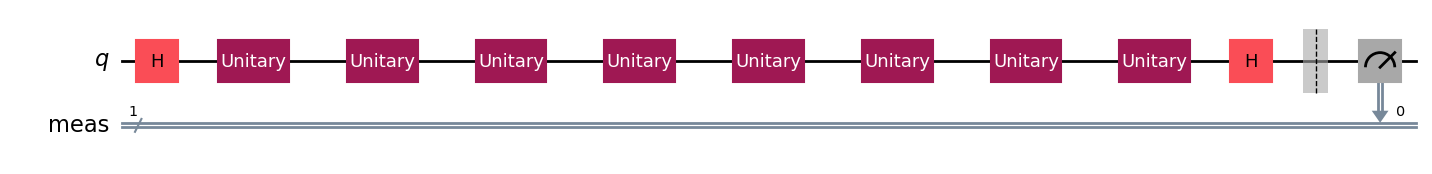

In [19]:
qc = QuantumCircuit(1)

qc.h(0)
for i in range(8):
    qc.append(cool, [0])
qc.h(0)

qc.measure_all()

sim = AerSimulator()
    
job = sim.run(qc, shots=100)

result = job.result()
counts = result.get_counts()

print(counts)
qc.draw("mpl")

In [22]:
qc = QuantumCircuit(1)

#qc.rz(+np.pi/8, 0)
qc.rz(-2*np.pi*(0.3/2), 0)

print("Original circuit:")
print(qc.draw())
 
basis = ["t", "h", "tdg"]
approx = generate_basic_approximations(basis, depth=10)
skd = SolovayKitaev(recursion_degree=2, basic_approximations=approx)
 
discretized = skd(qc)
 
print("Discretized circuit:")
print(discretized.draw())
 
print("Error:", np.linalg.norm(Operator(qc).data - Operator(discretized).data))

#discretized.draw("latex")

Original circuit:
   ┌────────────┐
q: ┤ Rz(-3π/10) ├
   └────────────┘
Discretized circuit:
global phase: π/8
   ┌───┐┌───┐┌───┐┌───┐┌───┐┌─────┐┌───┐┌─────┐┌───┐┌─────┐┌───┐┌─────┐┌───┐»
q: ┤ H ├┤ T ├┤ H ├┤ T ├┤ H ├┤ Tdg ├┤ H ├┤ Tdg ├┤ H ├┤ Tdg ├┤ H ├┤ Tdg ├┤ H ├»
   └───┘└───┘└───┘└───┘└───┘└─────┘└───┘└─────┘└───┘└─────┘└───┘└─────┘└───┘»
«   ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌─────┐┌───┐┌─────┐┌───┐┌─────┐┌───┐»
«q: ┤ T ├┤ H ├┤ T ├┤ T ├┤ H ├┤ T ├┤ H ├┤ Tdg ├┤ H ├┤ Tdg ├┤ H ├┤ Tdg ├┤ H ├»
«   └───┘└───┘└───┘└───┘└───┘└───┘└───┘└─────┘└───┘└─────┘└───┘└─────┘└───┘»
«   ┌─────┐┌───┐┌───┐┌───┐┌───┐┌───┐┌─────┐┌─────┐┌───┐┌─────┐┌───┐┌───┐┌───┐»
«q: ┤ Tdg ├┤ H ├┤ T ├┤ H ├┤ T ├┤ H ├┤ Tdg ├┤ Tdg ├┤ H ├┤ Tdg ├┤ H ├┤ T ├┤ H ├»
«   └─────┘└───┘└───┘└───┘└───┘└───┘└─────┘└─────┘└───┘└─────┘└───┘└───┘└───┘»
«   ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌─────┐┌───┐┌─────┐»
«q: ┤ T ├┤ H ├┤ T ├┤ H ├┤ T ├┤ H ├┤ T ├┤ T ├┤ H ├┤ T ├┤ H ├┤ Tdg ├┤ H ├┤ Tdg ├»
«   └───┘└───┘└───┘└───┘└──

In [92]:
circ = QuantumCircuit(1)
circ.rz(np.pi/8, 0)
basis = ["t", "tdg", "z", "h"]
approx = generate_basic_approximations(basis, depth=3)
skd = SolovayKitaev(recursion_degree=2, basic_approximations=approx)
rootT = skd(circ)

print("Discretized circuit:")
print(rootT.draw())
 
print("Error:", np.linalg.norm(Operator(circ).data - Operator(rootT).data))


Discretized circuit:
   ┌───┐┌───┐┌─────┐┌───┐┌─────┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌─────┐┌───┐»
q: ┤ T ├┤ H ├┤ Tdg ├┤ H ├┤ Tdg ├┤ H ├┤ T ├┤ H ├┤ T ├┤ H ├┤ T ├┤ H ├┤ Tdg ├┤ H ├»
   └───┘└───┘└─────┘└───┘└─────┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└─────┘└───┘»
«   ┌─────┐┌───┐
«q: ┤ Tdg ├┤ H ├
«   └─────┘└───┘
Error: 0.07944281142466891


In [23]:
hmm = discretized.data
h = 0
t = 0
decomp = []

for instruction in hmm:
    if instruction.name == "h":
        h+=1
        decomp.append("h")
    if instruction.name == "t":
        t+=1
        decomp.append("t")
    if instruction.name == "tdg":
        t+=1
        decomp.append("tdg")
    #print(instruction.name)

print("h: ",h, ", t/tdg: ",t)
print(decomp)
for i in range(len(decomp)-1):
    if decomp[i] == decomp[i+1]:
        if decomp[i] == "t":
            decomp[i+1] = "s"
            decomp [i] = 0
        if decomp[i] == "tdg":
            decomp[i+1] ="sdg"
            decomp [i] = 0
try:
    decomp.remove(0)
except ValueError:
    True

decomp = [i for i in decomp if i != 0]

for i in range(len(decomp)-1):
    if decomp[i] == decomp[i+1]:
        if decomp[i] == "s":
            decomp[i+1] = "z"
            decomp [i] = 0
        if decomp[i] == "sdg":
            decomp[i+1] ="z"
            decomp [i] = 0
try:
    decomp.remove(0)
except ValueError:
    True

decomp = [i for i in decomp if i != 0]
    
print("t/tdg: ", decomp.count("t")+decomp.count("tdg"))
print(decomp)

# decomp.reverse()

# latex = ""
# for i in decomp:
#     if i == "t":
#         latex = latex + "T"
#     if i == "tdg":
#         latex = latex + "T^\dagger "
#     if i == "s":
#         latex = latex + "S"
#     if i == "sdg":
#         latex = latex + "S^\dagger "
#     if i == "h":
#         latex = latex + "H"

# print(latex)

h:  64 , t/tdg:  77
['h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 'tdg', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'tdg', 'h', 'tdg', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'tdg', 'h', 'tdg', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 't', 't', 'h', 't', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't']
t/tdg:  53
['h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 's', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 'sdg', 'h', '

In [100]:
unit = np.array([[1,0],[0,1]])

t = np.array([[1,0],[0,np.exp((np.pi/4)*1j)]])

tdg = np.array([[1,0],[0,np.exp(-(np.pi/4)*1j)]])

s = np.array([[1,0],[0,np.exp((np.pi/2)*1j)]])

sdg = np.array([[1,0],[0,np.exp(-(np.pi/2)*1j)]])

h = np.array([[1,1],[1,-1]])
h = (1/np.sqrt(2))*h

# test = np.array([[1,0],[0,np.exp((2*np.pi*(1/16))*1j)]])

# #print(test)

# ok = np.matmul(unit,unit)

# for instruction in hmm:
#     if instruction.name == "t":
#         ok = np.matmul(ok, t)
#     if instruction.name == "tdg":
#         ok = np.matmul(ok, tdg)
#     if instruction.name == "h":
#         ok = np.matmul(ok, h)

In [101]:
def dist(U,approx):
    ehm = np.conjugate(U.T)
    next = np.matmul(ehm, approx)
    hmm = np.abs(np.trace(next))
    return np.sqrt((2-hmm)/2)

def T(a,b):
    b = b*np.exp(1j*(np.pi/4))
    return a,b

def A(a,b):                             # = T adjoint
    b = b*np.exp(-1j*(np.pi/4))
    return a,b

def S(a,b):                             
    b = b*np.exp(1j*(np.pi/2))
    return a,b

def B(a,b):                             # = S adjoint
    b = b*np.exp(-1j*(np.pi/2))
    return a,b

def H(a,b):
    a = (1/(2**0.5))*(a+b)
    b = (1/(2**0.5))*(a-b)
    return a,b

def dustin(k: int, tgates: int):
    combs = ["A","T", "S", "B"]
    val_a , val_b = [],[]
    for i in range(tgates-1):
        all1 = [i+"A" for i in combs]
        all2 = [i+"T" for i in combs]
        all3 = [i+"S" for i in combs]
        all4 = [i+"B" for i in combs]
        combs = all1 + all2 + all3 + all4
    for i in range(len(combs)):
        seq = combs[i]
        a = 0
        b = 1
        for i in seq:
            if i == "A":
                a,b = H(a,b)
                a,b = A(a,b)
            if i == "T":
                a,b = H(a,b)
                a,b = T(a,b)
            if i == "S":
                a,b = H(a,b)
                a,b = S(a,b)
            if i == "B":
                a,b = H(a,b)
                a,b = B(a,b)
        val_a.append(a)
        val_b.append(b)
    angle = np.exp((1j*2*np.pi)/(2**(k+3)))
    winner = 0
    old = 3
    for i in range(len(val_a)):
        mine = mymatrix(combs[i])
        test = np.array([[1,0],[0,angle]])
        distance = dist(test, mine)
        if distance < old:
            winner = i
            old = distance
    return combs[winner]

def dustin_ez(k: int, tgates: int):
    combs = ["A","T"]
    val_a , val_b = [],[]
    for i in range(tgates-1):
        all1 = [i+"A" for i in combs]
        all2 = [i+"T" for i in combs]
        combs = all1 + all2
    for i in range(len(combs)):
        seq = combs[i]
        a = 0
        b = 1
        for i in seq:
            if i == "A":
                a,b = H(a,b)
                a,b = A(a,b)
            if i == "T":
                a,b = H(a,b)
                a,b = T(a,b)
        val_a.append(a)
        val_b.append(b)
    angle = np.exp((1j*2*np.pi)/(2**(k+3)))
    winner = 0
    old = 3
    for i in range(len(val_a)):
        mine = mymatrix(combs[i])
        test = np.array([[1,0],[0,angle]])
        distance = dist(test, mine)
        if distance < old:
            winner = i
            old = distance
    return combs[winner]

def mymatrix(seq):
    ok1 = np.matmul(unit,unit)
    for i in range(len(seq)):
        if seq[i] == "A":
            ok1 = np.matmul(ok1,h)
            ok1 = np.matmul(ok1,tdg)
        if seq[i] == "T":
            ok1 = np.matmul(ok1,h)
            ok1 = np.matmul(ok1,t)
        if seq[i] == "S":
            ok1 = np.matmul(ok1,h)
            ok1 = np.matmul(ok1,s)
        if seq[i] == "B":
            ok1 = np.matmul(ok1,h)
            ok1 = np.matmul(ok1,sdg)
    return ok1

def kpbruder(decomp: list):
    lel = unit
    for i in decomp:
        if i == "t":
            lel = np.matmul(lel, t)
        elif i == "tdg":
            lel = np.matmul(lel, tdg)
        elif i == "sdg":
            lel = np.matmul(lel, sdg)
        elif i == "s":
            lel = np.matmul(lel, s)
        elif i == "h":
            lel = np.matmul(lel, h)
    return lel

In [102]:
test = np.array([[1,0],[0,np.exp((2*np.pi*((0.3-0.25)/2))*1j)]])

hmm = discretized.data
one = np.matmul(unit,unit)
ok = np.matmul(unit,unit)
for instruction in hmm:
    if instruction.name == "t":
        ok = np.matmul(ok, t)
    if instruction.name == "tdg":
        ok = np.matmul(ok, tdg)
    if instruction.name == "h":
        ok = np.matmul(ok, h)
    if instruction.name == "s":
        ok = np.matmul(ok, s)
    if instruction.name == "sdg":
        ok = np.matmul(ok, sdg)


print("Distanz zu SK: ", dist(test, ok))
print("Distanz zu Identity: ", dist(test, one))

Distanz zu SK:  0.006932737041886004
Distanz zu Identity:  0.0555217639027439


In [25]:
lelo = mymatrix(dustin_ez(1,8))

müde = kpbruder(decomp=decomp)          #mit approx vom square t gate
#bruh = kpbruder(decomp=decomp1)         #mit approx vom eigentlichen winkel 0.05 über SK

# x = [i+1 for i in range(15)]

# y = []
# for i in x:
#     skibidi = dustin_ez(1,i)
#     ok = mymatrix(skibidi)
#     bro = dist(test, ok)
#     y.append(bro)

# plt.plot(x,y)
# plt.yscale("log")

In [26]:
print("Abstand zu Einheitsmatrix lol: ", dist(test, müde))
print("Abstand zu Solovay Kitaev Decomp: ", dist(test, lelo))
#print("Abstand zu meins: ", dist(test, ok1))

Abstand zu Einheitsmatrix lol:  0.032613663027620685
Abstand zu Solovay Kitaev Decomp:  0.19522051007115346
